# Pruebas de Rendimiento Sistemas de Seguimiento

El seguimiento de múltiples objetos (MOT, por sus siglas en inglés) es una tarea que consiste en detectar diversos objetos de interés en un video, realizar el seguimiento de estos en los fotogramas subsiguientes, asignándoles una identificación única y manteniendo estas identificaciones a medida que los objetos se desplazan en el video.

El MOT toma un video continuo como entrada y lo divide en fotogramas discretos a una tasa de cuadros por segundo (fps) específica. Este procedimiento se centra en tres aspectos fundamentales: la detección, que identifica qué objetos están presentes en cada fotograma; la localización, que determina dónde se encuentran estos objetos dentro de cada fotograma; y la asociación, que establece si los objetos en diferentes fotogramas corresponden al mismo objeto o a objetos diferentes.

Para medir el rendimiento de los seguidores de objetos, es necesario siempre comparar los resultados obtenidos con una verdad de base (*Ground Truth*) sobre los cuales se deben identificar cinco tipos de errores:

- **Falsos Negativos (o Perdidas):** cuando un "Ground Truth" existe, pero el sistema no detecta nada.
- **Falsos Positivos:** donde existe una predicción del rastreador sin un "Ground Truth" detectado.
- **Combinación o Cambio de ID:** cuando las trayectorias de dos o más objetos se intercambian al pasar cerca uno del otro.
- **Fragmentación:** ocurre cuando una trayectoria de seguimiento de repente deja de ser rastreada, pero la trayectoria de verdad de base aún existe.
- **Desviación:** cuando una trayectoria de objeto se reinicializa con un ID de seguimiento diferente.

En este documento se busca describir el proceso de toma de pruebas de rendimiento a los sistemas de seguimiento aplicados para este proyecto. Las métricas seleccionadas para medir el rendimiento son: Tasa de Identificadores Nuevos, *Multi-Object Tracking Accuracy* (MOTA),  *Multi-Object Tracking Precision* (MOTP) y la métrica de identificación IDF1.

- **Tasa de Identificadores Nuevos:** representa la cantidad total de objetos únicos identificados a lo largo del tiempo (cuadros de video), es una manera sencilla de comparar visualmente aspectos como la fragmentación, desviación y combinación en un video de muestra.
- **MOTA:** combina los FN, FP y groundTruth a un nivel de detección, junto a la tasa de cambios de ID únicos a nivel de seguimiento. Busca responder ¿Qué tan preciso es el método para detectar los objetos únicos a lo largo del video? (Donde 0 representa una baja exactitud y 1 una alta).
- **MOTP:** calcula el promedio de la distancia entre las detecciones de la muestra y el *Ground Truth*. Buscando responder ¿Qué tan precisa es la detección? (Donde 0 representa una baja exactitud y 1 una alta).
- **IDF1:** calcula una correspondencia biyectiva (uno a uno) entre los conjuntos de trayectorias verdaderas y las trayectorias de la muestra para determinar la proporción de detección identificada correctamente. Busca responder ¿Qué tan preciso es el método para seguir los objetos a lo largo del video?

**MOTA analiza la precisión con la que se detectan los objetos únicos, mientras que IDF1 representa la precisión con la que se siguen los objetos únicos.

Para comenzar es necesario definir un *Ground Truth*. 




## Ground Truth

Para el desarrollo de la verdad de base, en este estudio se tomo la decisión de combinar los resultados entregados por la herramienta Data From sky (DFS), especializada en la detección y extracción de trayectorias de vehículos desde tomas cenitales, junto a un etiquetado manual de objetos. El formato del archivo es el definido por la librería `py-motmetrics` con la siguiente estructura:

``` Python

<frame number>, <object id>, <bb_left>, <bb_top>, <bb_width>, <bb_height>, <confidence>, <x>, <y>, <z>

```

El archivo `dfs_ground_truth.csv` contiene todas las deteciones de un video de muestra `video_sift_estabilizado_filtrado.mp4`, se puede encontrar en el directorio `research/tracking_methods/video reference DFS/` junto al presente documento. 

Es **importante** aclarar que las detecciones resultandes solo involucran a vehículos en movimiento, lo cual difieren un poco del desafio MOT16 por lo que puede afectar a los resultados asignando algunos falsos verdaderos que coinciden con los vehículos en estado estatico. Esto se debe a que los resultados exportados de DFS solo consideran las coordenadas de los vehículos en movimiento. A falta de un mejor ground truth se espera poder mejorar la calidad de este en un futuro.

## Dependencias y Variables Globales

In [74]:
from collections import defaultdict
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from ultralytics import YOLO
from sort import Sort
import csv
import os

VIDEO_REFERENCE = './video reference DFS/video_sift_estabilizado_filtrado.mp4'
CUSTOM_YOLO_MODEL = 'D:/Titulo/Github/vehicle_video_trajectory_extractor/research/tracking_methods/cutom_dota.pt'

## Obtener Prediciones con YOLOv8 + SORT



In [97]:
def resize_frame(frame, max_width=1280, max_height=720):
    h, w = frame.shape[:2]
    scale = min(max_width / w, max_height / h)
    new_w, new_h = int(w * scale), int(h * scale)
    return cv2.resize(frame, (new_w, new_h))

cap = cv2.VideoCapture(VIDEO_REFERENCE)
model = YOLO(CUSTOM_YOLO_MODEL)
tracker = Sort(max_age=15)

# Initialize CSV writer
with open('yolo_sort_detections.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    frame_number = 0
    while cap.isOpened():
        status, frame = cap.read()
        if not status:
            break

        results = model(frame, stream=True, verbose=False)
        for res in results:
            filtered_indices = np.where(res.boxes.conf.cpu().numpy() > 0.3)[0]
            data = res.boxes.data.cpu().numpy()[filtered_indices]
            tracks = tracker.update(data)

            for track in tracks:
                xmin, ymin, xmax, ymax, conf, class_id, track_id = track
                bb_width, bb_height = xmax - xmin, ymax - ymin
                track_id = int(track_id)
                x, y, z = -1, -1, -1

                # Write data to CSV
                writer.writerow([frame_number, track_id, xmin, ymin, bb_width, bb_height, conf, x, y, z])
                xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
                # Drawing results on frame (optional)
                cv2.putText(frame, f"Id: {track_id}", (xmin, ymin-10), cv2.FONT_HERSHEY_PLAIN, 2, (0,255,0), 2)
                cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        resized_frame = resize_frame(frame)
        cv2.imshow("frame", resized_frame)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

        frame_number += 1

cap.release()
cv2.destroyAllWindows()

## Obtener Predicciones YOLOv8 + Bytetrack

In [98]:
def yolov8_bytetrack_save_tracking_info(video_path, output_file_path):
    # Load the YOLOv8 model
    model = YOLO('D:/Titulo/Github/vehicle_video_trajectory_extractor/models/cutom_dota.pt')

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Open the output file
    with open(output_file_path, 'w') as output_file:
        frame_number = 0

        while cap.isOpened():
            # Read a frame from the video
            success, frame = cap.read()

            if success:
                # Run YOLOv8 tracking on the frame
                results = model.track(frame, persist=True, imgsz=1280, show_labels=False, show_conf=False, show_boxes=False)

                # Get the boxes, track IDs and confidences
                boxes = results[0].boxes.xywh.cpu()
                track_ids = results[0].boxes.id.int().cpu().tolist()
                confidences = results[0].boxes.conf.cpu().tolist()

                # Write tracking info to the output file
                for box, track_id, confidence in zip(boxes, track_ids, confidences):
                    x, y, w, h = box
                    bb_left = x - w / 2
                    bb_top = y - h / 2
                    output_file.write(f"{frame_number}, {track_id}, {bb_left}, {bb_top}, {w}, {h}, {confidence}, -1, -1, -1\n")

                # Display the annotated frame
                annotated_frame = results[0].plot()
                cv2.imshow("YOLOv8 Tracking", annotated_frame)
                
                frame_number += 1
                if cv2.waitKey(1) & 0xFF == ord("q"):
                    break
            else:
                break

        cap.release()
        cv2.destroyAllWindows()

# Example usage
output_file = "./yolo_bytetrack_detections.csv"
yolov8_bytetrack_save_tracking_info(VIDEO_REFERENCE, output_file)



0: 736x1280 1 large vehicle, 77 small vehicles, 257.2ms
Speed: 6.0ms preprocess, 257.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 large vehicle, 77 small vehicles, 213.2ms
Speed: 8.0ms preprocess, 213.2ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 large vehicle, 78 small vehicles, 209.2ms
Speed: 7.0ms preprocess, 209.2ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 large vehicle, 77 small vehicles, 208.2ms
Speed: 8.0ms preprocess, 208.2ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 large vehicle, 77 small vehicles, 207.2ms
Speed: 7.0ms preprocess, 207.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 large vehicle, 77 small vehicles, 215.2ms
Speed: 8.0ms preprocess, 215.2ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 large vehicle, 78 small vehicles, 217.2ms
Speed: 

## Remover Objetos Inmóviles

In [99]:
def read_tracking_data(file_path):
    data = defaultdict(list)
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            frame_number, object_id, bb_left, bb_top, *rest = row
            data[object_id].append((int(frame_number), float(bb_left), float(bb_top), *rest))
    return data

def significant_movement(data, threshold=0.08):
    to_keep = set()
    for object_id, positions in data.items():
        if len(positions) < 2:
            to_keep.add(object_id)
            continue

        initial_position = positions[0][1:3]  # (bb_left, bb_top)
        for pos in positions:
            displacement = max(abs(pos[1] - initial_position[0]), abs(pos[2] - initial_position[1]))
            if displacement > threshold * max(initial_position):
                to_keep.add(object_id)
                break
    return to_keep

def write_filtered_data(input_file_path, output_file_path, to_keep):
    with open(input_file_path, 'r') as infile, open(output_file_path, 'w', newline='') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)

        for row in reader:
            if row[1] in to_keep:
                writer.writerow(row)

# YOLO + SORT
input_file_path = './yolo_sort_detections.csv'

data = read_tracking_data(input_file_path)
output_file_path = './yolo_sort_detections_filtered.csv'
to_keep = significant_movement(data)
write_filtered_data(input_file_path, output_file_path, to_keep)

# YOLOv8 ByteTrack
input_file_path = './yolo_bytetrack_detections.csv'

data = read_tracking_data(input_file_path)
output_file_path = './yolo_bytetrack_detections_filtered.csv'
to_keep = significant_movement(data)
write_filtered_data(input_file_path, output_file_path, to_keep)

## Tasa de Identificadores Nuevos

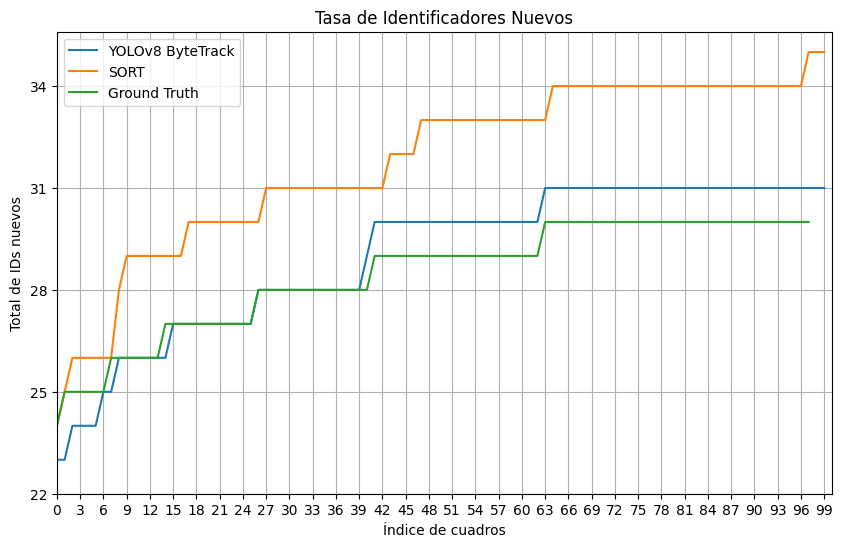

In [107]:
def track_cumulative_objects_per_frame(file_paths):
    """
    Tracks the cumulative count of unique IDs per frame.
    
    :param file_paths: List of paths to CSV files.
    :return: A list of lists, where each inner list contains the cumulative counts of unique IDs by frame.
    """
    all_files_cumulative_counts = []

    for file_path in file_paths:
        with open(file_path, 'r') as file:
            reader = csv.reader(file)
            frame_objects = {}
            seen_ids = set()
            cumulative_counts = []

            for row in reader:
                frame = int(row[0])
                obj_id = int(row[1])

                if frame not in frame_objects:
                    frame_objects[frame] = set()
                frame_objects[frame].add(obj_id)

            for frame in sorted(frame_objects.keys()):
                new_ids = frame_objects[frame] - seen_ids
                seen_ids.update(new_ids)
                cumulative_counts.append(len(seen_ids))

            # If there are frames with no new IDs, they need to be filled in the list
            max_frame = max(frame_objects.keys())
            while len(cumulative_counts) <= max_frame:
                cumulative_counts.append(cumulative_counts[-1])

            all_files_cumulative_counts.append(cumulative_counts)
    
    return all_files_cumulative_counts

def plot_cumulative_new_ids(cumulative_ids_series, labels=None):
    """
    Plots multiple series of cumulative new IDs in different colors.
    
    :param cumulative_ids_series: A list of lists, where each inner list is a series of cumulative new IDs.
    :param labels: An optional list of labels for each series.
    """
    plt.figure(figsize=(10, 6))
    
    for i, series in enumerate(cumulative_ids_series):
        if labels and i < len(labels):
            plt.plot(series, label=labels[i])
        else:
            plt.plot(series)
    
    plt.xlabel("Índice de cuadros")
    plt.ylabel("Total de IDs nuevos")
    plt.title("Tasa de Identificadores Nuevos")
    plt.legend() if labels else None

    # Adjusting grid lines
    max_x = len(cumulative_ids_series[0])
    max_y = max(cumulative_ids_series[1])
    plt.xticks(np.arange(0, max_x, max_x // 30))  # Divide x-axis into 20 intervals
    plt.yticks(np.arange(22, max_y + 1, max_y // 10))  # Divide y-axis into 10 intervals
    plt.xlim(0, max_x)
    plt.grid(True)
    plt.show()

# Usage
file_paths = ['./yolo_bytetrack_detections_filtered.csv', './yolo_sort_detections_filtered.csv', './video reference DFS/dfs_ground_truth.csv']  # Replace with actual file paths
unique_objects_per_frame = track_cumulative_objects_per_frame(file_paths) # Assuming 'object id' is at index 1 and 'frame number' is at index 0

plot_cumulative_new_ids(unique_objects_per_frame, labels=['YOLOv8 ByteTrack', 'SORT', 'Ground Truth'])

## Metricas MOT16

In [105]:
def motMetricsEnhancedCalculator(gtSource, tSource, name=None):
    # import required packages
    import motmetrics as mm
    import numpy as np
  
    # load ground truth
    gt = np.loadtxt(gtSource, delimiter=',')

    # load tracking output
    t = np.loadtxt(tSource, delimiter=',')

    # Create an accumulator that will be updated during each frame
    acc = mm.MOTAccumulator(auto_id=True)

    # Max frame number maybe different for gt and t files
    for frame in range(int(gt[:,0].max())):
        frame += 1 # detection and frame numbers begin at 1

        # select id, x, y, width, height for current frame
        gt_dets = gt[gt[:,0] == frame, 1:6] # select all detections in gt
        t_dets = t[t[:,0] == frame, 1:6] # select all detections in t

        C = mm.distances.iou_matrix(gt_dets[:,1:], t_dets[:,1:], max_iou=0.5)

        # Call update once for per frame
        acc.update(gt_dets[:,0].astype('int').tolist(), t_dets[:,0].astype('int').tolist(), C)

    mh = mm.metrics.create()

    # Compute only MOTA, MOTP, IDF1 metrics
    summary = mh.compute(acc, metrics=['mota', 'motp', 'idf1'], name='prediction' if name is None else name)

    strsummary = mm.io.render_summary(
        summary,
        namemap={'idf1': 'IDF1', 'mota': 'MOTA', 'motp': 'MOTP'}
    )
    print(strsummary)

# Usage example
detections_file = "./yolo_sort_detections_filtered.csv"
gt_file = "./video reference DFS/dfs_ground_truth.csv"
motMetricsEnhancedCalculator(gt_file, detections_file, name="YOLOv8 SORT")

detections_file = "./yolo_bytetrack_detections_filtered.csv"
gt_file = "./video reference DFS/dfs_ground_truth.csv"
motMetricsEnhancedCalculator(gt_file, detections_file, name = "ByteTrack  ")


                 MOTA      MOTP      IDF1
YOLOv8 SORT  0.673137  0.132723  0.837155
                 MOTA      MOTP      IDF1
ByteTrack    0.681677  0.125661  0.841553


### Herramientas de Previsualización

In [85]:
import cv2
import csv
import random
from collections import defaultdict

def read_tracking_data(file_path):
    data = defaultdict(list)
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            frame_number, object_id, *bbox = row
            data[int(frame_number)].append((object_id, tuple(map(float, bbox))))
    return data

def assign_random_colors(tracking_data):
    colors = {}
    unique_ids = set(object_id for frames in tracking_data.values() for object_id, _ in frames)
    for object_id in unique_ids:
        colors[object_id] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    return colors

def draw_bboxes(frame, frame_number, tracking_data, colors):
    for object_id, bbox in tracking_data.get(frame_number, []):
        bb_left, bb_top, bb_width, bb_height, *_ = bbox
        top_left = int(bb_left), int(bb_top)
        bottom_right = int(bb_left + bb_width), int(bb_top + bb_height)
        cv2.rectangle(frame, top_left, bottom_right, colors[object_id], 2)
        cv2.putText(frame, str(object_id), (top_left[0], top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, colors[object_id], 2)

def process_video(video_path, tracking_data_path):
    tracking_data = read_tracking_data(tracking_data_path)
    colors = assign_random_colors(tracking_data)

    cap = cv2.VideoCapture(video_path)
    frame_number = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_number += 1
        draw_bboxes(frame, frame_number, tracking_data, colors)
        cv2.putText(frame, f'Frame {frame_number}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow("Video", frame)

        # Wait for space bar press to advance to the next frame
        key = cv2.waitKey(0)  # Wait indefinitely for a key press
        if key == 32:  # Space bar key
            continue
        elif key == ord('q'):  # Exit loop if 'q' is pressed
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage
output_file_path = './video reference DFS/dfs_ground_truth.csv'
process_video(VIDEO_REFERENCE, output_file_path)


In [2]:
import cv2
import csv
import random
from collections import defaultdict

def read_tracking_data(file_path):
    data = defaultdict(list)
    with open(file_path, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            frame_number = int(row['frame_n'])
            object_id = row['class_id']
            tx, ty, bx, by = map(float, [row['tx'], row['ty'], row['bx'], row['by']])
            data[frame_number].append((object_id, tx, ty, bx, by))
    return data

def assign_random_colors(tracking_data):
    colors = {}
    unique_ids = set(object_id for frames in tracking_data.values() for object_id, *_ in frames)
    for object_id in unique_ids:
        colors[object_id] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    return colors

def draw_bboxes(frame, frame_number, tracking_data, colors):
    for object_id, tx, ty, bx, by in tracking_data.get(frame_number, []):
        top_left = int(tx), int(ty)
        bottom_right = int(bx), int(by)
        cv2.rectangle(frame, top_left, bottom_right, colors[object_id], 2)
        cv2.putText(frame, str(object_id), (top_left[0], top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, colors[object_id], 2)

def process_video(video_path, tracking_data_path):
    tracking_data = read_tracking_data(tracking_data_path)
    colors = assign_random_colors(tracking_data)

    cap = cv2.VideoCapture(video_path)
    frame_number = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_number += 1
        draw_bboxes(frame, frame_number, tracking_data, colors)

        cv2.imshow("Video", frame)

        # Wait for space bar press to advance to the next frame
        key = cv2.waitKey(0)  # Wait indefinitely for a key press
        if key == 32:  # Space bar key
            continue
        elif key == ord('q'):  # Exit loop if 'q' is pressed
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage
video_path = "D:/Titulo/Github/vehicle_video_trajectory_extractor/research/tracking_methods/video_reference/vid_1_[180,220][00,99]_2_ss_cvat1.1/video_sift_estabilizado_filtrado.mp4"
output_file_path = 'D:/Titulo/Github/vehicle_video_trajectory_extractor/research/tracking_methods/video_reference/vid_1_[180,220][00,99]_2_ss_cvat1.1/labels.csv'
process_video(video_path, output_file_path)
